In [65]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Unconditional Latent Diffusion Training

In this notebook, we will train a simple `LatentDiffusion` model in low resolution (64 by 64).

The training should take about 20 hours for reasonable results.

---

Maps dataset from the pix2pix paper:
```bash
wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
tar -xvf maps.tar.gz
```

In [87]:
import os, sys, argparse
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import seed_everything

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from src import *

mpl.rcParams['figure.figsize'] = (8, 8)
sys.argv = ['ipykernel_launcher.py']

In [88]:
parser = argparse.ArgumentParser()
parser.add_argument("--image_size", type=int, default=256, help="Image size")
parser.add_argument("--train_dataset", type=str, default="./afhq/train", help="The path to your training dataset")
parser.add_argument("--val_dataset", type=str, default="./afhq/val", help="The path to your training dataset")
parser.add_argument("--device", type=int, default=0 if torch.cuda.is_available() else "cpu", help="Device number.")
parser.add_argument("--num_workers", type=int, default=0, help="Spawn how many processes to load data.")
parser.add_argument("--seed", type=int, default=42, help='manual seed')
parser.add_argument("--max_epochs", type=int, default=1000, help="Max epoch number to run.")
parser.add_argument("--ckpt_path", type=str, default="", help="Checkpoint path to load.")
parser.add_argument("--save_path", type=str, default="./ckpt/", help="Checkpoint path to save.")
parser.add_argument("--save_freq", type=int, default=1, help="Save model every how many epochs.")
parser.add_argument("--batch_size", type=int, default=8, help="Entry numbers every batch.")
parser.add_argument("--lr", type=float, default=1e-4, help="Learning rate for your optimizer.")
parser.add_argument("--ddim_steps", type=int, default=50, help="DDIM timesteps")
args = parser.parse_args()
seed_everything(args.seed)

Global seed set to 42


42

In [83]:
import kornia
from kornia.utils import image_to_tensor
import kornia.augmentation as KA


class SimpleImageDataset(Dataset):
    """Dataset returning images in a folder."""

    def __init__(self,
                 root_dir,
                 transforms = None):

        self.root_dir = root_dir
        self.transforms = transforms

        # set up transforms
        if self.transforms is not None:
            data_keys = ['input']

            self.input_T = KA.container.AugmentationSequential(
                *self.transforms,
                data_keys = data_keys,
                same_on_batch = False
            )

        # check files
        supported_formats = ['webp', 'jpg']

        # TODO begin: Define the image paths filtered by the `supported_formats` in your datasets
        # Hint: os.listdir
        # Challenge: Can you complete this task in one line ? (hint: Python comprehension, refer to Python basics handout by Yifan Li)
        self.image_names = [name for name in os.listdir(self.root_dir)]
        # TODO end

    def __len__(self):
        # TODO begin: Return the length of your dataset
        return len(self.image_names)
        # TODO end

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_names[idx])
        image = image_to_tensor(imageio.imread(img_name)) / 255

        if self.transforms is not None:
            image = self.input_T(image)[0]

        return image


In [89]:
import torchvision.transforms as T

CROP_SIZE = args.image_size

transform = [
    KA.RandomCrop((2 * CROP_SIZE,2 * CROP_SIZE)),
    KA.Resize((CROP_SIZE, CROP_SIZE), antialias=True),
    KA.RandomVerticalFlip()
  ]

train_dataset = SimpleImageDataset(args.train_dataset, transforms=transform)
val_dataset = SimpleImageDataset(args.val_dataset, transforms=transform)


In [98]:
# TODO begin: Define the training dataloader using torch.utils.data.DataLoader
# Hint: you can refer to the val_dataloader below, pay attention to the `shuffle` parameter
train_dataloader = DataLoader(train_dataset,
           batch_size=args.batch_size,
           shuffle=True,
           num_workers=4)
# TODO end
val_dataloader = DataLoader(val_dataset,
                            batch_size=args.batch_size,
                            shuffle=False,
                            num_workers=4)


### Model Training

In [91]:
# TODO begin: complete the LatentDiffusion Model in `src`
model = LatentDiffusion(lr = args.lr, batch_size = args.batch_size)
# TODO end

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Is Time embed used ?  True


...but first, let's check if the used `AutoEncoder` (`model.vae`) can reconstruct our samples well.

**You should always test your autoencoder in this way when using latent diffusion models on a new dataset.**

C:\Users\admin\AppData\Local\Temp\ipykernel_42372\3088237227.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = image_to_tensor(imageio.imread(img_name)) / 255
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'AutoEncoder Reconstruction')

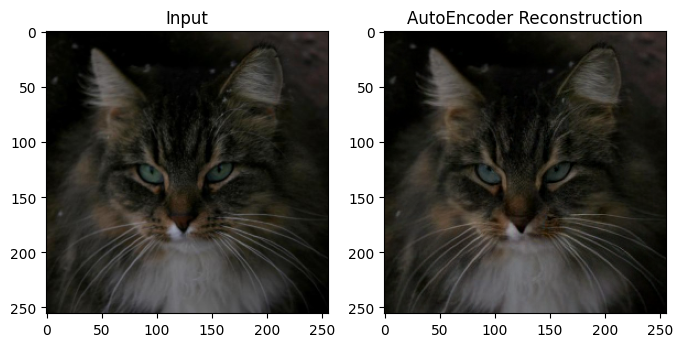

In [92]:
img = train_dataset[0]

# TODO begin: Show the example img and use vae to reconstruct it using matplotlib
# Hint: plt.imshow
# Challenge: What's the image shape here? Should you permute or unsqueeze it?
plt.subplot(1,2,1)
# Plot the original img here
plt.imshow(img.permute(1, 2, 0))
plt.title('Input')

plt.subplot(1,2,2)
# Plot the reconstructed img by `mode.vae` here
plt.imshow(model.vae(img.unsqueeze(0))[0].detach().cpu().permute(1, 2, 0))
plt.title('AutoEncoder Reconstruction')
# TODO end

In [93]:
# Define the trainer using PyTorch Lightning
trainer = pl.Trainer(
    max_steps = 2e5,
    callbacks = [EMA(0.9999)]
)

e:\2023\2023 summer\sast2023\solution\src\EMA.py:58: UserWarning: EMA has better performance when Apex is installed: https://github.com/NVIDIA/apex#installation.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [99]:
# Easy to train the model in PyTorch Lightning in one line
trainer.fit(model, train_dataloaders=train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | vae   | AutoEncoder               | 83.7 M
1 | model | DenoisingDiffusionProcess | 56.6 M
----------------------------------------------------
56.6 M    Trainable params
83.7 M    Non-trainable params
140 M     Total params
561.084   Total estimated model params size (MB)


In [ ]:
model.to(args.device)
out = model(batch_size = args.batch_size, shape = (64,64), verbose = True)

In [ ]:
for idx in range(out.shape[0]):
    plt.subplot(1, len(out), idx+1)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')

By default, the `DDPM` sampler contained in the model is used, as above.

However, you can use a `DDIM` sampler just as well to reduce the number of inference steps:

In [ ]:
ddim_sampler = DDIM_Sampler(args.ddim_steps, model.model.num_timesteps)

model.to(args.device)
out = model(batch_size=args.batch_size, sampler=ddim_sampler, shape=(64,64), verbose=True)

In [ ]:
for idx in range(out.shape[0]):
    plt.subplot(1,len(out),idx+1)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')